In [1]:
import matplotlib.pyplot as plt
import numpy as np

import nengo
from nengo.utils.ensemble import sorted_neurons
from nengo.utils.matplotlib import rasterplot

# Transformations
from neuroptimiser.utils import tro2s, trs2o

from ioh import get_problem


In [2]:

PROBLEM_ID      = 12  # Problem ID from the IOH framework
PROBLEM_INS     = 1  # Problem instance
NUM_DIMENSIONS  = 10  # Number of dimensions for the problem

problem         = get_problem(fid=PROBLEM_ID, instance=PROBLEM_INS, dimension=NUM_DIMENSIONS)
problem.reset()
print(problem)

X_LOWER_BOUND   = problem.bounds.lb
X_UPPER_BOUND   = problem.bounds.ub
X_INITIAL_GUESS = np.random.uniform(X_LOWER_BOUND, X_UPPER_BOUND, NUM_DIMENSIONS)

# Keep copies of the original global bounds
X_LOWER_BOUND0 = X_LOWER_BOUND.copy()
X_UPPER_BOUND0 = X_UPPER_BOUND.copy()

# Exploitation (search-space shrinking) schedule
SHRINK_EVERY     = 1.0     # seconds between shrink operations
SHRINK_RATE      = 0.5     # geometric shrink factor (0.8 → shrink by 20%)
# MIN_WIDTH_FRAC   = 0.02    # do not shrink any dimension below 2% of the original range


<RealSingleObjectiveProblem 12. BentCigar (iid=1 dim=10)>


In [3]:

# Create the Nengo model
model = nengo.Network(label="nNeurOpti V1", seed=69)
with model:
    # INITIALISATION
    # --------------------------------------------------------------
    v0_state    = tro2s(X_INITIAL_GUESS, X_LOWER_BOUND, X_UPPER_BOUND)
    # Input nodes for the bounds and initial guess
    # input_x_l    = nengo.Node(label="x_l", output=X_LOWER_BOUND)
    # input_x_u    = nengo.Node(label="x_u", output=X_UPPER_BOUND)
    # input_x_0    = nengo.Node(label="x_0", output=X_INITIAL_GUESS)

    # LOCAL STATE
    state = {
        "best_v": v0_state.copy(),
        "best_f": None,
        "lb": X_LOWER_BOUND.copy(),
        "ub": X_UPPER_BOUND.copy(),
        "last_upd": 0.0,
        "last_shrink": 0.0,
        "best_x": None,          # best in ORIGINAL space
        "retarget_until": 0.0,   # time until which we inject best_v after a shrink
    }

    # Evaluate the objective function
    def f_obj(t, state_vector):
        """Evaluate the objective function at the given state vector."""
        v       = np.clip(state_vector, -1.0, 1.0)  # Ensure within bounds, consider toroidal space later
        x_vals  = trs2o(v, state["lb"], state["ub"])
        # Implement here the transformation for integer variables if needed
        fv      = problem(x_vals)
        return np.concatenate((v, [fv]))

    state["best_f"] = f_obj(None, v0_state)[-1]
    state["best_x"] = trs2o(state["best_v"], state["lb"], state["ub"])

    def init_pulse(t):
        if t < 0.01:
            return v0_state.copy()
        return np.zeros(NUM_DIMENSIONS)

    init_node = nengo.Node(output=init_pulse, size_out=NUM_DIMENSIONS)

    # State ensemble
    neurons_per_dim     = 100
    ea             = nengo.networks.EnsembleArray(
        label           = "ens_array",
        n_neurons       = neurons_per_dim,
        n_ensembles     = NUM_DIMENSIONS,
        ens_dimensions  = 1,
        radius          = 1.0,
        intercepts  = nengo.dists.Uniform(-0.9, 0.9),
        max_rates   = nengo.dists.Uniform(80,220),
        encoders    = nengo.dists.UniformHypersphere(surface=True),
        neuron_type     = nengo.AdaptiveLIF(
            # initial_state   = {
            #     "voltage": nengo.dists.Uniform(-1.0, 1.0),
            #     "refractory_time": np.zeros(n_neurons)
            # },
            # min_voltage     = -1.0,
        ),
        # noise=nengo.processes.WhiteNoise(dist=nengo.dists.Gaussian(0, 0.5), seed=42),
    )

    nengo.Connection(init_node, ea.input, synapse=None)

    # Recurrent connection to hold the state
    eta = 0.6 # "Learning rate"
    def hs(t, x):
        if state["best_v"] is None:
            return np.zeros_like(x)
        # best_v = state["best_v"]
        return x + eta * (state["best_v"] - x)
        # return x + eta * (best_v - x) + np.random.normal(0, 0.1, size=x.shape)  # Add some noise for exploration

    tau     = 0.1
    # nengo.Connection(
    #     label       = "recurrent",
    #     pre         = motor_ens.output,
    #     post        = motor_ens.input,
    #     synapse     = tau,
    #     function    = hs,
    #     transform   = np.eye(NUM_DIMENSIONS),
    # )
    hs_node = nengo.Node(
        label       = "hs",
        size_in     = NUM_DIMENSIONS,
        size_out    = NUM_DIMENSIONS,
        output      = hs
    )

    # Route state through hs_node, then feed back into the EA input
    nengo.Connection(ea.output, hs_node, synapse=0)
    nengo.Connection(hs_node, ea.input, synapse=tau, transform=np.eye(NUM_DIMENSIONS))

    # Encoding function for the initial guess in state space within [-1, 1]
    # input_v0    = nengo.Node(label="v0_state", output=v0_state.copy())

    # nengo.Connection(input_v0, ens_lif, synapse=None)

    # Connect to the objective function node
    obj_node    = nengo.Node(
        label="f_obj",
        output=f_obj,
        size_in=NUM_DIMENSIONS,
        size_out=NUM_DIMENSIONS+1
    )
    nengo.Connection(
        pre     = ea.output,
        post    = obj_node,
        synapse = 0,
    )

    # ====
    def local_selector(t, x):
        v       = x[:NUM_DIMENSIONS]
        fv      = float(x[NUM_DIMENSIONS])
        if state["best_f"] is None or (fv < state["best_f"] and t >= 0.01):
            state["best_f"] = fv
            state["best_v"] = v.copy()
            # store best in ORIGINAL space under current dynamic bounds
            state["best_x"] = trs2o(state["best_v"], state["lb"], state["ub"])

        if state["best_v"] is None:
            return np.concatenate((v, [fv]))
        else:
            return np.concatenate((state["best_v"], [state["best_f"]]))

    selector_node   = nengo.Node(
        label="selector",
        output=local_selector,
        size_in=NUM_DIMENSIONS + 1,
        size_out=NUM_DIMENSIONS + 1,
    )
    nengo.Connection(obj_node, selector_node, synapse=0)
    # ====

    # Controller towards the best-so-far
    # eta = 0.2 # Learning rate or movement rate towards the best
    # def controller(t, x):
    #     best_v  = x[:NUM_DIMENSIONS]
    #     curr_v  = x[NUM_DIMENSIONS:]
    #     return eta * (best_v - curr_v)

    # control_node = nengo.Node(
    #     label="controller",
    #     output=controller,
    #     size_in=2 * NUM_DIMENSIONS,
    #     size_out=NUM_DIMENSIONS,
    # )

    # nengo.Connection(selector_node[:NUM_DIMENSIONS], control_node[:NUM_DIMENSIONS], synapse=0)
    # nengo.Connection(ens_lif, control_node[NUM_DIMENSIONS:], synapse=0)      # Current state vector

    # nengo.Connection(control_node, ens_lif, synapse=0.01)  # Apply control to the ensemble

    fbest_only = nengo.Node(
        size_in=NUM_DIMENSIONS+1,
        size_out=1,
        output=lambda t, x: x[-1]
    )
    nengo.Connection(selector_node, fbest_only, synapse=0)

    xbest_only = nengo.Node(
        size_in=NUM_DIMENSIONS+1,
        size_out=NUM_DIMENSIONS,
        output=lambda t, x: trs2o(x[:NUM_DIMENSIONS], state["lb"], state["ub"])
    )
    nengo.Connection(selector_node, xbest_only, synapse=0)

    # Shrinking scheduler node: periodically narrows the bounds
    def schedule_shrink(t):
        # Trigger every SHRINK_EVERY seconds after a short warmup
        if t < 0.1 or t - state["last_shrink"] < SHRINK_EVERY:
            return 0.0
        if state["best_v"] is None:
            return 0.0

        # Current dynamic bounds and global bounds
        lb, ub      = state["lb"], state["ub"]
        glb, gub    = X_LOWER_BOUND0, X_UPPER_BOUND0
        # Current widths and target widths after shrinking
        width       = (ub - lb) * SHRINK_RATE
        min_width   = 1e-12 #(gub - glb) * MIN_WIDTH_FRAC

        # Center the new box around the current best (in ORIGINAL space of current bounds)
        center      = trs2o(state["best_v"], lb, ub)
        # Enforce minimum width and clip to global box
        new_lb      = np.maximum(center - 0.5 * np.maximum(width, min_width), glb)
        new_ub      = np.minimum(center + 0.5 * np.maximum(width, min_width), gub)

        # Ensure numerical ordering
        eps = 1e-12
        new_lb = np.minimum(new_lb, new_ub - eps)
        new_ub = np.maximum(new_ub, new_lb + eps)

        # Recompute best_v under the NEW bounds so it stays centred on the same best_x
        if state["best_x"] is not None:
            new_best_v = tro2s(state["best_x"], new_lb, new_ub)
        else:
            new_best_v = state["best_v"]

        state["lb"], state["ub"] = new_lb, new_ub
        state["best_v"] = np.clip(new_best_v, -1.0, 1.0)
        # briefly retarget the EA to the new best_v to avoid jumps after a shrink
        state["retarget_until"] = t + 0.02
        state["last_shrink"] = t
        return 1.0  # Node must output something

    # A standalone scheduler node (no connections needed)
    shrink_node = nengo.Node(output=schedule_shrink, size_out=1, label="shrink_scheduler")

    def retarget_pulse(t):
        if t <= state["retarget_until"] and state["best_v"] is not None:
            return state["best_v"]
        return np.zeros(NUM_DIMENSIONS)

    retarget_node = nengo.Node(output=retarget_pulse, size_out=NUM_DIMENSIONS, label="retarget_pulse")
    nengo.Connection(retarget_node, ea.input, synapse=None)

    # input_probe = nengo.Probe(v_0, synapse=0.01)
    shrink_trigger = nengo.Probe(shrink_node, synapse=None)
    ens_lif_val = nengo.Probe(ea.output, synapse=0.01)  # 10ms filter
    obj_val     = nengo.Probe(obj_node[-1], synapse=0)
    fbest_val   = nengo.Probe(fbest_only, synapse=0.01)
    xbest_val   = nengo.Probe(xbest_only, synapse=0.01)
    ea_spk      = [nengo.Probe(ens.neurons, synapse=0.01) for ens in ea.ensembles]


In [4]:
simulation_time = 20.0  # seconds

# Create our simulator
with nengo.Simulator(model) as sim:
    # Run it for 1 second
    sim.run(simulation_time)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [5]:
print("Evals", len(sim.data[obj_val]))
print(f"{'xid':3s}: {'lower':>8s} {'upper':>8s}, {'xbest':>8s} :: {'xopt':>7s} | {'diff':>7s}")
print("-" * 55)
for i in range(NUM_DIMENSIONS):
    print(f" x{i+1:02d}: [{np.min(sim.data[xbest_val][:,i]):.4f}, {np.max(sim.data[xbest_val][:,i]):.4f}], ", end="")
    print(f"{sim.data[xbest_val][-1][i]:7.4f} :: {problem.optimum.x[i]:7.4f} | {sim.data[xbest_val][-1][i] - problem.optimum.x[i]:7.4f}")

print(f"fbest: {sim.data[fbest_val][-1][0]:.4f} (opt: {problem.optimum.y}), diff: {sim.data[fbest_val][-1][0] - problem.optimum.y:.4f}")

Evals 20000
xid:    lower    upper,    xbest ::    xopt |    diff
-------------------------------------------------------
 x01: [-2.9646, 0.8497], -1.0259 :: -0.8920 | -0.1339
 x02: [0.0000, 4.9921],  4.0011 ::  3.9912 |  0.0099
 x03: [-2.9310, 2.3697], -0.1326 ::  0.1712 | -0.3038
 x04: [-5.0000, 0.0000], -3.6487 :: -3.8008 |  0.1521
 x05: [-2.9505, 0.5643], -0.0240 :: -0.4688 |  0.4448
 x06: [-2.6149, 0.5353], -1.9631 :: -2.0888 |  0.1257
 x07: [-1.4128, 2.5523],  1.2844 ::  1.3840 | -0.0996
 x08: [-2.8766, 0.1095], -0.7646 :: -0.7344 | -0.0302
 x09: [-3.1839, 1.9231],  1.3152 ::  1.1456 |  0.1696
 x10: [-0.7172, 0.8580], -0.3670 :: -0.3040 | -0.0630
fbest: -620.7787 (opt: -621.11), diff: 0.3313


In [6]:
x = sim.data[xbest_val][-1]
f = problem(x)
print(f"f(xbest): {f:.4f} (opt: {problem.optimum.y}), diff: {f - problem.optimum.y:.4f}")

f(xbest): -620.7787 (opt: -621.11), diff: 0.3313


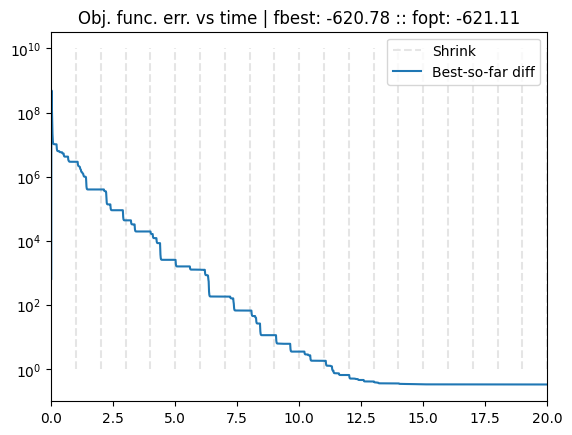

In [7]:
plt.figure()
# plt.plot(sim.trange(), sim.data[obj_val] - problem.optimum.y, label="Objective value")
plt.vlines(sim.data[shrink_trigger].nonzero()[0]*sim.dt, 1e0, 1e10, colors="grey", linestyles="dashed", label="Shrink", alpha=0.2)
plt.plot(sim.trange(), sim.data[fbest_val] - problem.optimum.y, label="Best-so-far diff") #"Best-so-far value")
plt.xlim(0, simulation_time)
plt.yscale("log")
plt.legend()
plt.title(f"Obj. func. err. vs time | fbest: {sim.data[fbest_val][-1][0]:.2f} :: fopt: {problem.optimum.y}")
plt.show()

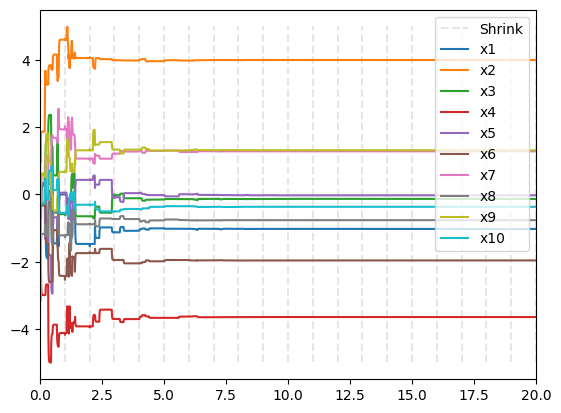

In [8]:
# Plot the decoded output of the ensemble
plt.figure()
# plt.plot(sim.trange(), sim.data[ens_lif_val], label=[f"x{i+1}" for i in range(NUM_DIMENSIONS)])
plt.vlines(sim.data[shrink_trigger].nonzero()[0]*sim.dt, -5, 5, colors="grey", linestyles="dashed", label="Shrink", alpha=0.2)
plt.plot(sim.trange(), sim.data[xbest_val], label=[f"x{i+1}" for i in range(NUM_DIMENSIONS)])
# plt.plot(sim.trange(), sim.data[input_probe], "r", label="Input")
plt.xlim(0, simulation_time)
plt.legend()
plt.show()

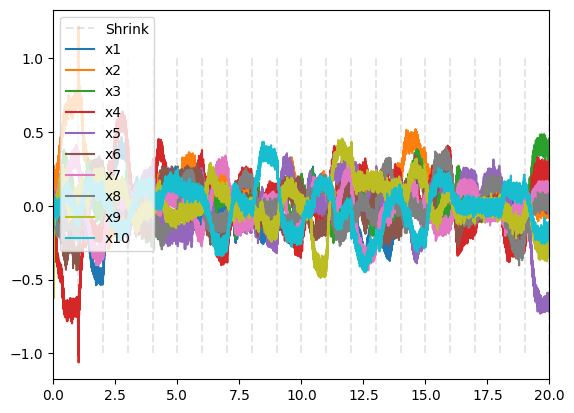

In [9]:
# Plot the decoded output of the ensemble
plt.figure()
plt.vlines(sim.data[shrink_trigger].nonzero()[0]*sim.dt, -1, 1, colors="grey", linestyles="dashed", label="Shrink", alpha=0.2)
plt.plot(sim.trange(), sim.data[ens_lif_val], label=[f"x{i+1}" for i in range(NUM_DIMENSIONS)])
# plt.plot(sim.trange(), sim.data[xbest_val], label=[f"x{i+1}" for i in range(NUM_DIMENSIONS)])
# plt.plot(sim.trange(), sim.data[input_probe], "r", label="Input")
plt.xlim(0, simulation_time)
plt.legend()
plt.show()

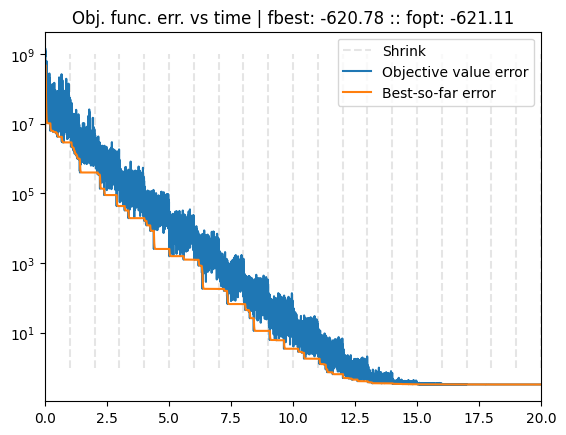

In [10]:
plt.figure()
plt.vlines(sim.data[shrink_trigger].nonzero()[0]*sim.dt, 1e0, 1e9, colors="grey", linestyles="dashed", label="Shrink", alpha=0.2)
plt.plot(sim.trange(), sim.data[obj_val] - problem.optimum.y, label="Objective value error")
plt.plot(sim.trange(), sim.data[fbest_val] - problem.optimum.y, label="Best-so-far error")
# plt.hlines(problem.optimum.y, 0, simulation_time, colors="r", linestyles="dashed", label="Optimal value")
# plt.plot(sim.trange(), sim.data[fbest_val] - problem.optimum.y, label="Best-so-far diff") #"Best-so-far value")
plt.xlim(0, simulation_time)
plt.yscale("log")
plt.legend()
plt.title(f"Obj. func. err. vs time | fbest: {sim.data[fbest_val][-1][0]:.2f} :: fopt: {problem.optimum.y}")
plt.show()

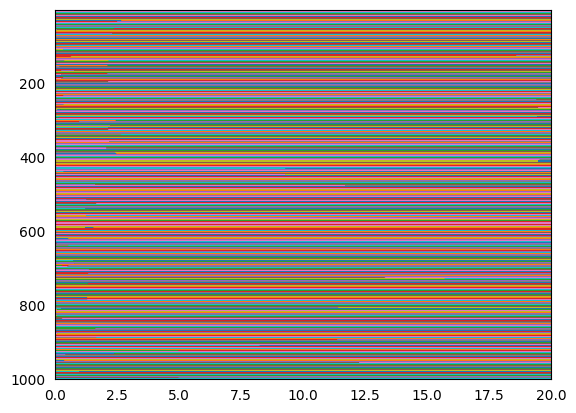

In [11]:
# Plot the spiking output of the ensemble
plt.figure()
spikes_cat = np.hstack([sim.data[p] for p in ea_spk])
rasterplot(sim.trange(), spikes_cat) #, use_eventplot=True)
plt.xlim(0, simulation_time)
plt.show()


In [12]:
# # For interest's sake, you can also sort by encoder
# indices = sorted_neurons(ens_lif, sim, iterations=250)
# plt.figure()
# rasterplot(sim.trange(), sim.data[ens_lif_spk][:, indices])
# plt.xlim(0, simulation_time)
# plt.show()